# Modelo de Clusterização para Análise das Métricas RFV

O modelo RFV (Recência, Frequência e Valor) é uma metodologia usada principalmente no marketing e em análises de comportamento do consumidor para segmentar clientes com base em seus hábitos de compra. Ele ajuda as empresas a identificar os clientes mais valiosos e direcionar estratégias de retenção e engajamento.
<br>
<br>

**Componentes do RFV:**
1. Recência (R):
  - Mede quanto tempo se passou desde a última interação ou compra de um cliente.
  - Clientes que compraram recentemente são mais propensos a interagir novamente.

2. Frequência (F):
  - Mede o número de vezes que o cliente comprou em um período específico.
  - Clientes que compram frequentemente são mais engajados e valiosos.

3. Valor (V):
  - Refere-se ao valor monetário gasto pelo cliente em compras anteriores.
  - Identifica clientes com maior impacto financeiro.

**Como funciona a análise RFV?**

1. Coleta de dados:
  - São coletados dados de transações, incluindo datas das compras, frequência e valores gastos.

2. Pontuação RFV:
  - Cada cliente recebe uma pontuação em cada dimensão (R, F e V).
  - Exemplo: Pontuar de 1 a 5, onde 5 indica alta recência, frequência ou valor, e 1 indica baixa.

3. Segmentação:

  - Os clientes são agrupados em categorias baseadas em suas pontuações.

  - Exemplo de segmentos:
    - Melhores clientes: Altas pontuações em R, F e V;
    - Clientes em risco: Alta frequência e valor no passado, mas baixa recência;
    - Novos clientes: Alta recência, mas baixa frequência e valor;
    - Clientes perdidos: Baixas pontuações em R, F e V.

4. Aplicação de estratégias:

  - A segmentação orienta ações de marketing, como campanhas específicas para cada grupo.
  <br>
<br>
**Benefícios do RFV:**
- Foco em clientes mais valiosos, maximizando o retorno do investimento;
- Melhora na personalização das estratégias de marketing;
- Priorização de retenção e reativação de clientes.

## Case

  - Utilizar um modelo de Clustering para criar um sistema de agrupamento de perfis de clientes para um e-commerce.

### Metadados
  - Os Metadados originais estão disponíveis na versão do dataset no [Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data).

  - Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

**Atenção:** as datas estão no formato MM/DD/YYYY HH:mm:ss; existem dados nulos que precisam ser tratados antes da realização da análise; por mais que os códigos de identificação sejam numéricos, o modelo não pode considerá-los como grandezas numéricas.

### Clusterização
Com base nesses dados, você precisa agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:

- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

## Setup


In [ ]:
%%capture
%pip install sidetable

In [ ]:
# Data cleaning and wrangling
import pandas as pd
import numpy as np
import sidetable
import datetime
import math
from ipywidgets import interact

# Data visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, scale, PowerTransformer, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# model
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors

# metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import kelbow_visualizer, KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

# Config
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregar dataset
DATA = pd.read_csv('../data/ecommerce_data.csv', encoding='latin1')

In [ ]:
# isolando um dataframe para pipeline e outro para data understand
customer = DATA.copy() # pipeline

df = DATA.copy() # EDA

# Tamanho do dataset
df.shape

(541909, 8)

## Data understand

In [ ]:
# Visualizar dataset
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- 'CustomerID' deve ser convertido para Object ou Category
- Para melhor compreensão na etapa de data understand, 'Description' pode ser preenchido de acordo com o 'StockCode', pois este é o código do produto faltante (ver a correlação de 'StockCode' com 'Description')
- 'UnitPrice' -> vamos assumir para fins didáticos que o valor do 'UnitPrice' está em libras (dataset com origem em Londes).

In [ ]:
# Descrição de variávies numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


- As colunas Quantity e UnitPrice possuem muitos outliers.
Eles serão tratados posteriormente.
- Quantity tem valores negativos: não faz sentido um cliente comprar uma quantidade negativa.

In [ ]:
# Verificar estatísticas descritivas dos dados categóricos
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [ ]:
# Função para interagir com o dataframe

object_cols = df.columns[df.dtypes==object]

@interact(target_column=object_cols, freq=['absolute','relative'])
def count_categories(target_column, freq):
    if freq == 'relative':
        return df[target_column].value_counts(normalize=True)
    else:
        return df[target_column].value_counts()

interactive(children=(Dropdown(description='target_column', options=('InvoiceNo', 'StockCode', 'Description', …

In [ ]:
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [ ]:
# Filtrando nulos
df.isna().any()

,0
InvoiceNo,False
StockCode,False
Description,True
Quantity,False
InvoiceDate,False
UnitPrice,False
CustomerID,True
Country,False


In [ ]:
# Filtrando e somando nulos
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
# Percentual de nulos
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


Apenas as colunas Description e CustomerID possuem valores nulos.

In [ ]:
# Recuperando valores únicos
df[['CustomerID', 'InvoiceNo', 'StockCode', 'Description']].nunique()

,0
CustomerID,4372
InvoiceNo,25900
StockCode,4070
Description,4223


- Existem 4372 clientes únicos;
- Há 25900 pedidos, isso indica que os pedidos foram feitos com vários itens;
A realidade é que a base tem mais de 500 mil registros, mas tem cerca de 4 mil registros únicos. Ou seja, são compras feitas pelos mesmos clientes para os mesmos produtos.

Como há cerca de 400 mil registros de CustomerID, mas apenas 4372 únicos, optarei por utilizar a transformação para category.

## Data preparation

### Transformação de variáveis

In [ ]:
# Converter CustomerID e Country para object
df[['CustomerID', 'Country']] = df[['CustomerID', 'Country']].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [ ]:
# converter a coluna InvoiceDate para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# cálculo da data da última compra

df['InvoiceDate'].agg(['min', 'max', 'median'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00
median,2011-07-19 17:17:00


In [ ]:
# agrupar a descrição pelo StockCode
df_stock = df.groupby(by='StockCode')['Description'].sum().isna()
df_stock #.nunique()

,Description
StockCode,
10002,False
10080,False
10120,False
10123C,False
10123G,False
...,...
gift_0001_20,False
gift_0001_30,False
gift_0001_40,False


In [ ]:
# agrupar a descrição pelo StockCode
df_desc = df.groupby(by='Description')['StockCode'].sum().isna()
df_desc #.nunique()

,StockCode
Description,
4 PURPLE FLOCK DINNER CANDLES,False
50'S CHRISTMAS GIFT BAG LARGE,False
DOLLY GIRL BEAKER,False
I LOVE LONDON MINI BACKPACK,False
I LOVE LONDON MINI RUCKSACK,False
...,...
wrongly marked carton 22804,False
wrongly marked. 23343 in box,False
wrongly sold (22719) barcode,False


### Nulos e Duplicados

In [ ]:
# Mostrando valores duplicados
df[df.duplicated(keep=False)].sort_values(df.columns.tolist())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
440149,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,2011-11-04 13:25:00,2.95,15110.0,United Kingdom
461407,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,2011-11-13 11:38:00,0.55,17838.0,United Kingdom
461408,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,2011-11-13 11:38:00,0.55,17838.0,United Kingdom
529980,C580764,22667,RECIPE BOX RETROSPOT,-12,2011-12-06 10:38:00,2.95,14562.0,United Kingdom


In [ ]:
# new_df: df com atalho partindo direto para remoção de dados duplicados e nulos
new_df = df.drop_duplicates()
new_df = new_df.dropna()
new_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### Preenchimento Description

In [ ]:
# Preencher Description de acordo com o StockCode
df_full = df

# Criar um dicionário para mapear StockCode à primeira descrição não nula
stock_description_map = df_full.dropna(subset=['Description']).drop_duplicates(subset=['StockCode']).set_index('StockCode')['Description']

# Preencher os valores nulos na coluna Description
df_full['Description'] = df_full['Description'].fillna(df['StockCode'].map(stock_description_map))

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541797 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df_full['Description'].isna().sum()

112

In [ ]:
# Filtrando as linhas onde 'Description' é nulo
df_nulos_description = df_full[df_full['Description'].isna()]

# Exibir o DataFrame filtrado
df_nulos_description[['Description', 'CustomerID']].notna().sum()

,0
Description,0
CustomerID,0


Onde os valores de Description são nulos, também os valores de CostumerID são nulos.
Diante disso, acredito que vale a pena remover estes nulos.

- CustomerID possui **135.080 nulos** e 406.829 registros preenchidos

In [ ]:
# remover duplicados
df_drop = df_full.drop_duplicates()
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  536529 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  object        
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.8+ MB


In [ ]:
df_dropped = df_drop.dropna()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  object        
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


### Datasets diponíveis

- `df`: dataset com o conjunto de dados principal. No qual foi realizada a compreensão dos dados e conversão dos tipos de dados.

- `new_df`: este dataset é um atalho. Pois foi diretamente para remoção de duplicados e nulos. Ao final consta o mesmo número de registros: 401.604.

- `df_full`: é o dataset `df`com a coluna 'Description' preenchida com base no 'StockCode'.
Foram recuperadas descrições de outras linhas com o mesmo 'StockCode' para preencher linhas nulas da coluna 'Description'.

- `df_dropped`: dataset que possui 401.604 registros e constituído das seguintes etapas:
  - Conversão dos tipos de dados;
  - Preenchimento de valores faltantes na coluna Description;
  - Remoção de nulos da coluna CustomerID, que reverbeou no dataset inteiro, mas que amenizou mais remoções porque valores faltantes na coluna Description foram preenchidos.
  - Remoção de linhas duplicadas.
<br>
<br>


**Seguiremos com o dataset `new_df`.**




### Filtros

In [ ]:
# Verificar se há valores menores que 0
valores_negativos = new_df['Quantity'] < 0
valores_negativos.sum()

8872

In [ ]:
# Verificar se há valores menores que 0
valores_inf = np.isinf(new_df['Quantity'])
valores_inf.sum()

0

Há 8.872 valores negativos e nenhum valor infinito na coluna 'Quantity'.

A partir de então irei filtrar somente os dados positivos e criar um novo dataset.

In [ ]:
# Novo dataset com valores positivos de quantity
new_df = new_df[new_df['Quantity'] >= 0]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  object        
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [ ]:
new_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,392732.0,13.153718,1.0,2.0,6.0,12.0,80995.0,181.58842
InvoiceDate,392732,2011-07-10 19:15:24.576301568,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392732.0,3.125596,0.0,1.25,1.95,3.75,8142.75,22.240725


Tem algum produto custando 0.00 Libras?


In [ ]:
new_df[new_df['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


In [ ]:
zero_price = (new_df['UnitPrice'] == 0).sum()
zero_price

40

Não faz sentido ter um produto custando 0 libras na base de dados. Essa inconsistência precisa ser repassada ao Stakeholder.

Nesse caso específico removerei esses valores do dataset.

In [ ]:
new_df = new_df[new_df['UnitPrice'] > 0.00]
new_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,392692.0,13.119702,1.0,2.0,6.0,12.0,80995.0,180.492832
InvoiceDate,392692,2011-07-10 19:13:07.771892480,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392692.0,3.125914,0.001,1.25,1.95,3.75,8142.75,22.241836


Interessante ainda ter produto custando 0.001 libras, mas como ainda é possível, manterei.

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [ ]:
new_df.sort_values(by='UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405.0,United Kingdom
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom
286813,562044,16045,POPART WOODEN PENCILS ASST,100,2011-08-02 10:24:00,0.040,16607.0,United Kingdom
...,...,...,...,...,...,...,...,...
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.950,15502.0,United Kingdom
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.320,12744.0,Singapore
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.060,12536.0,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.060,12536.0,France


### Outliers


In [ ]:
new_df.describe().T


,count,mean,min,25%,50%,75%,max,std
Quantity,392692.0,13.119702,1.0,2.0,6.0,12.0,80995.0,180.492832
InvoiceDate,392692,2011-07-10 19:13:07.771892480,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN
UnitPrice,392692.0,3.125914,0.001,1.25,1.95,3.75,8142.75,22.241836


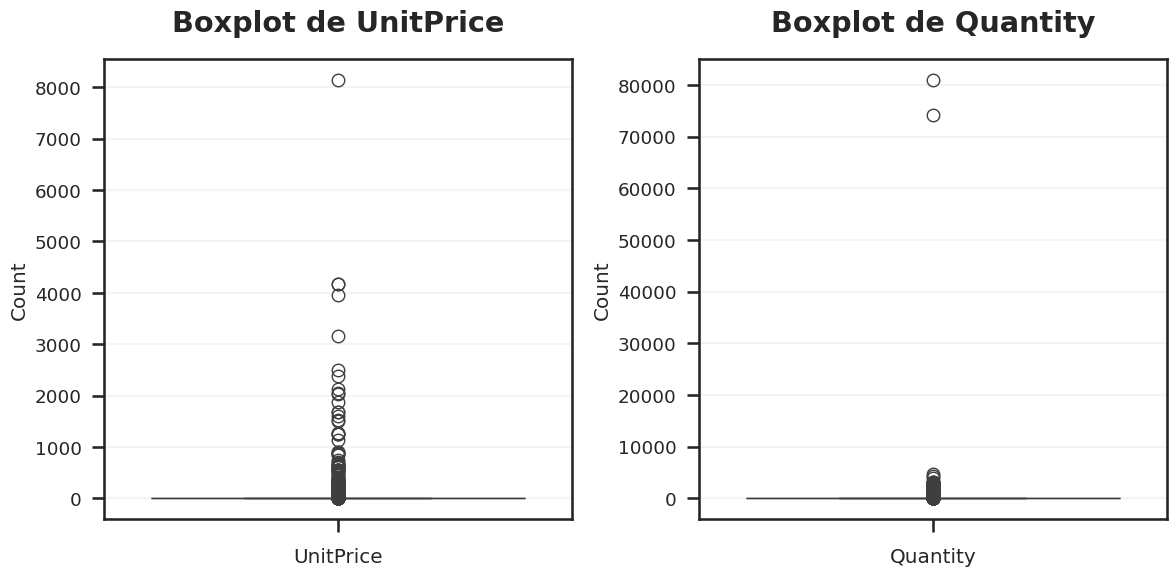

In [ ]:
# Configuração do tamanho da figura
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 linha, 2 colunas

# Boxplot para a coluna UnitPrice
sns.boxplot(data=new_df, y='UnitPrice', ax=axes[0])
axes[0].set_title('Boxplot de UnitPrice')
axes[0].set_xlabel('UnitPrice')
axes[0].set_ylabel('Count')

# Boxplot para a coluna Quantity
sns.boxplot(data=new_df, y='Quantity', ax=axes[1])
axes[1].set_title('Boxplot de Quantity')
axes[1].set_xlabel('Quantity')
axes[1].set_ylabel('Count')

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()

<Axes: >

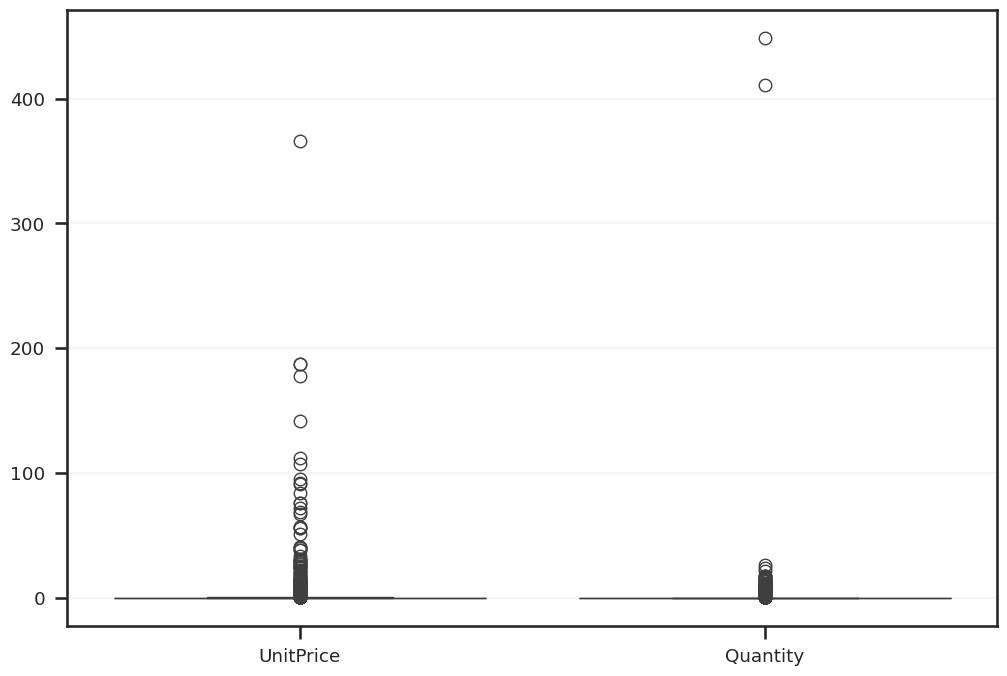

In [ ]:
# boxplot com dados padronizados

sns.boxplot(data=new_df[['UnitPrice', 'Quantity']].apply(scale)) #plot.box()

In [ ]:
# Função customizada para identificar outlier

def is_outlier (array, extreme = False):
  """Função customizada para identificar outliers em um array"""
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor * iqr
  lower_outlier = q1 - factor * iqr
  return (array < lower_outlier)|(array > upper_outlier)

In [ ]:
# Filtro para exibir apenas os outliers na coluna Quantity ou na UnitPrice
outlier = new_df[new_df[['Quantity', 'UnitPrice']].apply(is_outlier).any(axis=1)]
outlier

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047.0,United Kingdom
19,536367,21777,RECIPE BOX WITH METAL HEART,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom
20,536367,48187,DOORMAT NEW ENGLAND,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom
...,...,...,...,...,...,...,...,...
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom
541866,581583,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36,2011-12-09 12:23:00,1.85,13777.0,United Kingdom
541867,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,2011-12-09 12:25:00,0.72,13777.0,United Kingdom
541868,581584,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,48,2011-12-09 12:25:00,1.85,13777.0,United Kingdom


In [ ]:
outlier.sort_values(by='UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
144826,548813,M,Manual,1,2011-04-04 13:03:00,2382.92,12744.0,Singapore
406407,571751,M,Manual,1,2011-10-19 11:18:00,2118.74,12744.0,Singapore
144829,548820,M,Manual,1,2011-04-04 13:04:00,2053.07,12744.0,Singapore
343000,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom


Os maiores outliers estão envolvidos com postagens e entradas manuais. Seria interessante que os stakeholders verificassem esses casos.

In [ ]:
# identificar a quantidade de outliers na coluna Quantity

is_outlier(new_df.Quantity).sum()

25616

In [ ]:
# identificar a quantidade de outliers na coluna UnitPrice

is_outlier(new_df.UnitPrice).sum()

34112

Há 59.458 linhas com outliers nas colunas 'Quantity' e/ou 'UnitPrice'. E a maior parte delas pertence à coluna 'UnitPrice'.

In [ ]:
# Função para remover outliers com base na função is_outlier que identifica outliers
def remove_outliers(df, columns, extreme=False):
    """Remove outliers from specified columns in a DataFrame"""
    df = df.copy()
    for col in columns:
        outliers = is_outlier(df[col], extreme)
        df = df[~outliers]
    return df

In [ ]:
# Removendo outliers das colunas 'UnitPrice' e 'Quantity'
clean_df = remove_outliers(new_df, columns=['UnitPrice', 'Quantity'], extreme=False)

# dataset sem outliers
clean_df


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333234 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 22.9+ MB


In [ ]:
clean_df[['Quantity', 'UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,333234.0,7.550682,6.777237,1.000,2.00,6.00,12.00,27.0
UnitPrice,333234.0,2.194218,1.546015,0.001,1.25,1.65,2.95,7.5


O dataset `clean_df`está livre de outliers e com 333.234 registros.

Pensando em melhor identificar os Clusters, optarei por não remover os outliers. Portanto, para a clusterização seguirei com o dataset `new_df`.


In [ ]:
# criar coluna TotalPrice para gerar gráficos e calculo do rfm

clean_df['TotalPrice'] = clean_df['Quantity'] * clean_df['UnitPrice']
clean_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


### Gráficos

In [ ]:
# função para gerar histogramas com a fórmula de Sturges
def plot_hist(df, colunas=None):
    """
    Gera histogramas para as colunas especificadas de um DataFrame utilizando a Fórmula de Sturges.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    colunas (list, opcional): Lista de colunas a serem plotadas. Se None, todas as colunas numéricas serão usadas.

    Retorno:
    None
    """
    if colunas is None:
        # Seleciona apenas colunas numéricas
        colunas = df.select_dtypes(include=['number']).columns.tolist()

    for coluna in colunas:
        dados = df[coluna].dropna()  # Remove valores nulos
        n = len(dados)
        if n == 0:
            print(f"A coluna '{coluna}' não contém dados suficientes para plotar.")
            continue

        # Calcula o número de classes usando a Fórmula de Sturges
        k = math.ceil(1 + 3.322 * math.log10(n))

        # Gera o histograma
        plt.figure(figsize=(8, 5))
        plt.hist(dados, bins=k, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"Histograma de {coluna} (K={k} classes)", fontsize=14)
        plt.xlabel(coluna, fontsize=12)
        plt.ylabel('Frequência', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

#### Histogramas

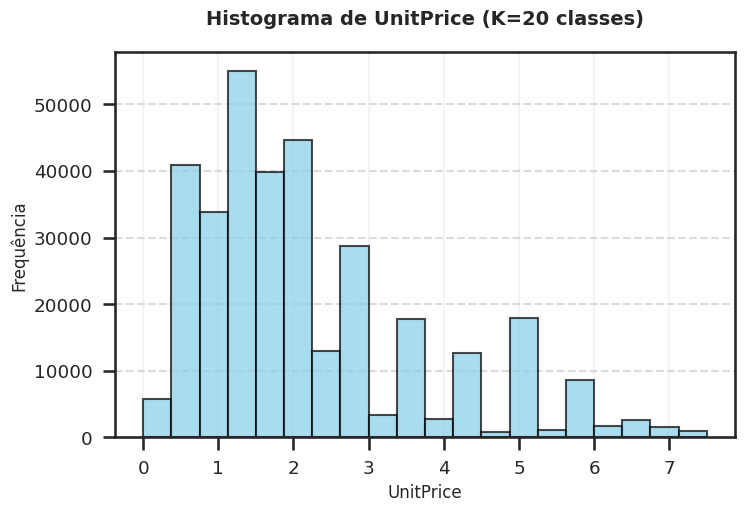

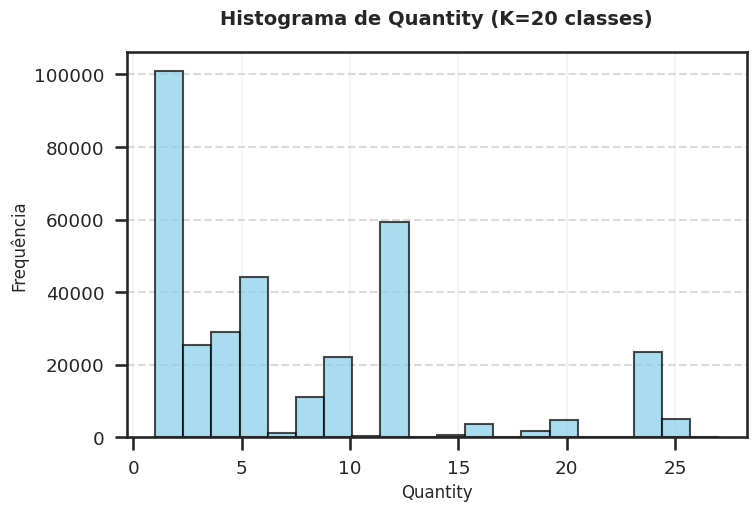

In [ ]:
# Gerar histogramas para colunas específicas com a fórmula de Sturges
plot_hist(clean_df, colunas=["UnitPrice", "Quantity"])

<Axes: xlabel='UnitPrice', ylabel='Count'>

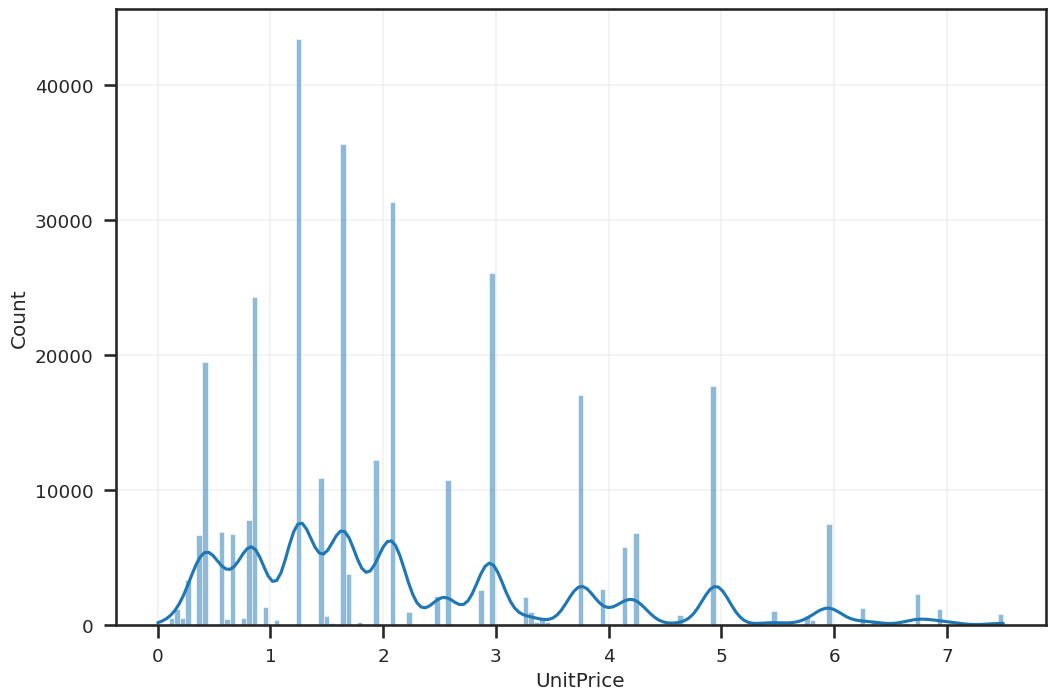

In [ ]:
# histograma de UnitPrice com seaborn
sns.histplot(data=clean_df, x='UnitPrice', kde=True)

<Axes: xlabel='Quantity', ylabel='Count'>

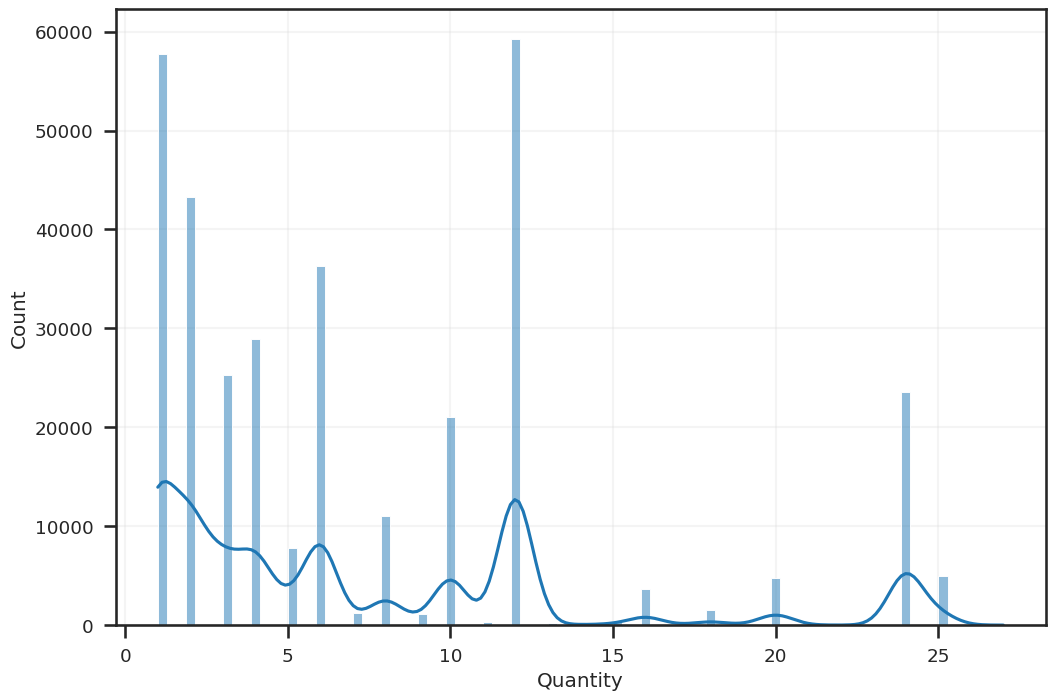

In [ ]:
# histograma de Quantity com seaborn
sns.histplot(data=clean_df, x='Quantity', kde=True)

#### Correlação

In [ ]:
# corr
clean_df[['UnitPrice', 'Quantity']].corr()

,UnitPrice,Quantity
UnitPrice,1.000000,-0.349846
Quantity,-0.349846,1.000000


<Axes: xlabel='UnitPrice', ylabel='Quantity'>

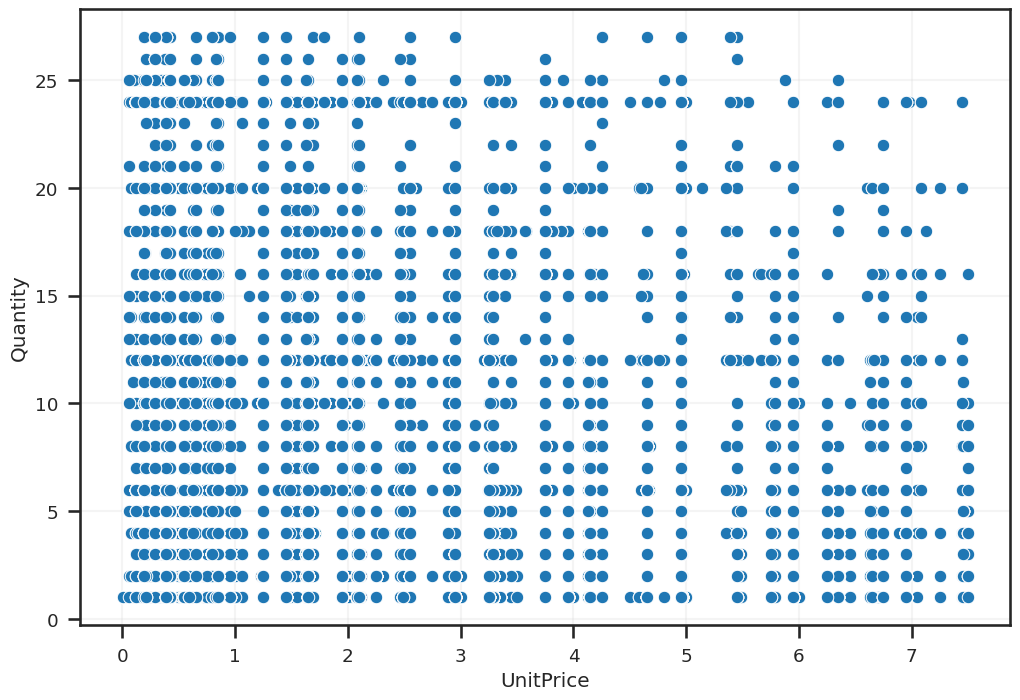

In [ ]:
sns.scatterplot(data=clean_df, x='UnitPrice', y='Quantity')

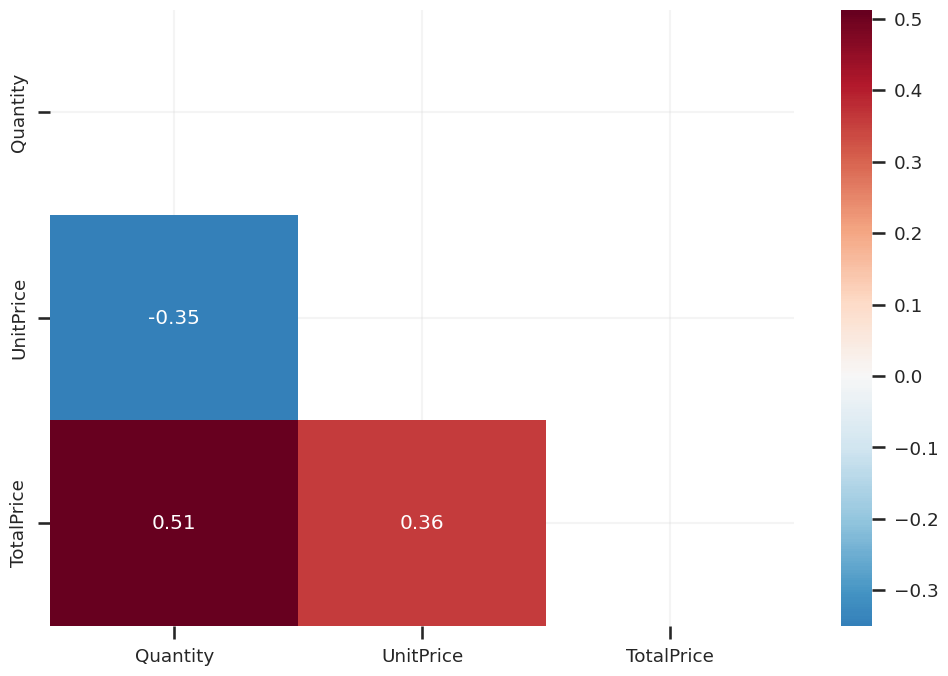

In [ ]:
# correlação de Pearson

df_p = clean_df.corr(numeric_only=True, method='pearson')

# heatmap
mask = np.triu(np.ones_like(df_p, dtype=bool))
sns.heatmap(df_p, cmap='RdBu_r', center=0, annot=True, fmt='.2f', mask=mask);

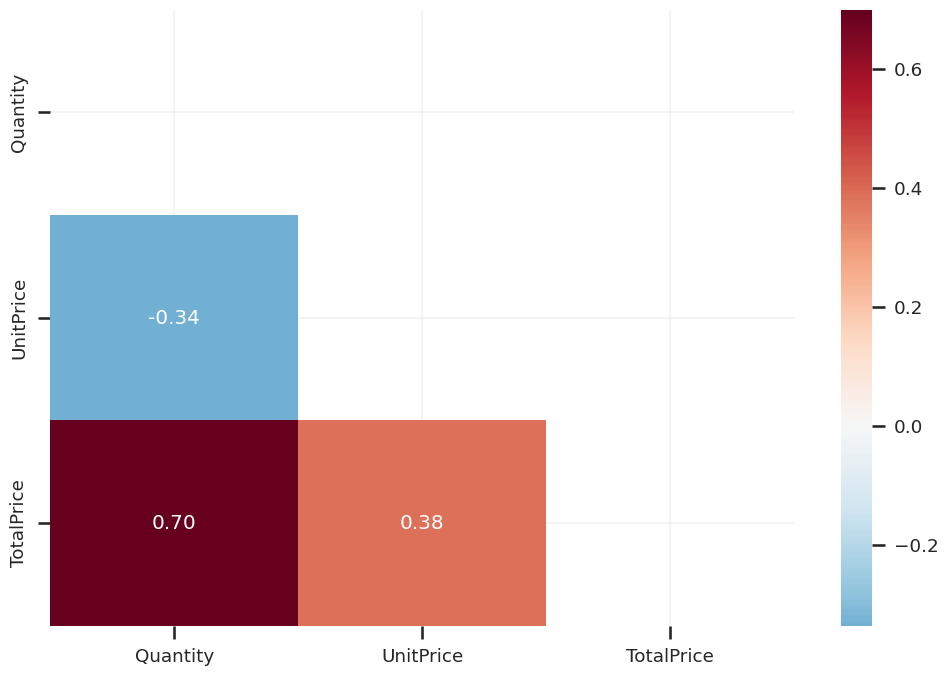

In [ ]:
# correlação de Spearman

dfc_s = clean_df.corr(numeric_only=True, method='spearman')

# heatmap
mask = np.triu(np.ones_like(dfc_s, dtype=bool))
sns.heatmap(dfc_s, cmap='RdBu_r', center=0, annot=True, fmt='.2f', mask=mask);

#### Categorias

In [ ]:
clean_df.groupby('Country', as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False).head(10)

,Country,TotalPrice
35,United Kingdom,3680989.464
14,Germany,137946.330
13,France,121978.940
10,EIRE,105899.620
30,Spain,29826.960
32,Switzerland,29790.460
3,Belgium,27839.110
26,Portugal,20408.770
24,Norway,18123.260
23,Netherlands,15578.900


<ipython-input-60-74f3a2235b23>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x='TotalPrice', y='Country', palette='viridis', order=top_countries.sort_values('TotalPrice', ascending=False).Country)


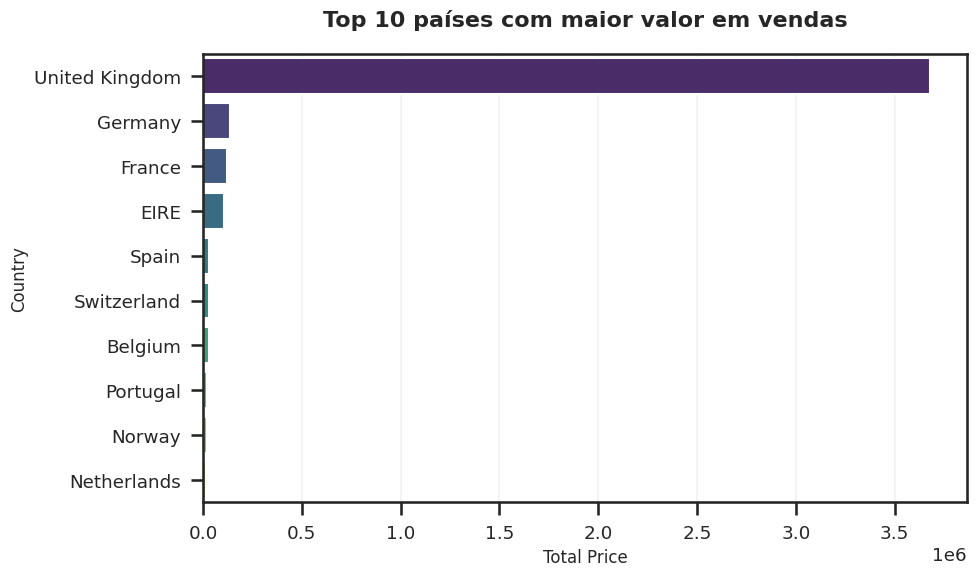

In [ ]:
# Calcula os 10 países com maior TotalPrice
top_countries = clean_df.groupby('Country', as_index=False)['TotalPrice'].sum() \
    .sort_values(by='TotalPrice', ascending=False).head(10)

# Cria o gráfico de barras com ordenação explícita
plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='TotalPrice', y='Country', palette='viridis', order=top_countries.sort_values('TotalPrice', ascending=False).Country)

# Personaliza o gráfico
plt.title('Top 10 países com maior valor em vendas', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()

# Mostra o gráfico
plt.show()


Faz sentido ser o Reino Unido porque é a sede do e-commerce. Isso indica que o maior montante de vendas é para clientes nacionais.

<ipython-input-61-4861c98f5f23>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x='TotalPrice', y='Description', palette='viridis', dodge=False).set(xticklabels=[]);


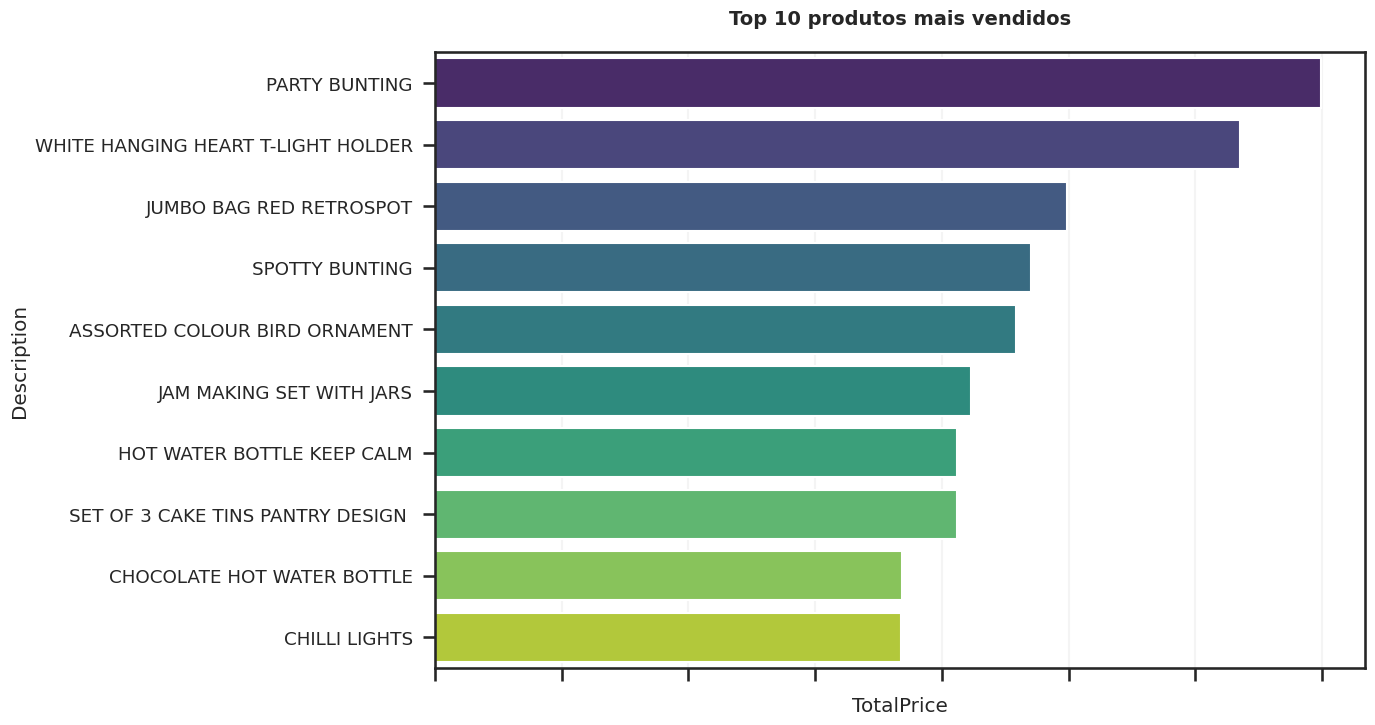

In [ ]:
# Top 10 produtos mais vendidos (StockCode)

top_products = clean_df.sort_values(['TotalPrice'], ascending=False).reset_index(drop=True)

top_products = clean_df.groupby('Description', as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False).head(10)

sns.barplot(data=top_products, x='TotalPrice', y='Description', palette='viridis', dodge=False).set(xticklabels=[]);

plt.title('Top 10 produtos mais vendidos', loc='center', fontsize=14);

In [ ]:
# Extrair o mês da coluna InvoiceDate
clean_df['Month'] = clean_df['InvoiceDate'].dt.strftime('%m')
clean_df['Year-Month'] = clean_df['InvoiceDate'].dt.strftime('%Y-%m')
clean_df['Year-Month'] = clean_df['Year-Month'].astype('datetime64[ns]')
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333234 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
 8   TotalPrice   333234 non-null  float64       
 9   Month        333234 non-null  object        
 10  Year-Month   333234 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 30.5+ MB


In [ ]:
# Quantidade de vendas por país (top 10 países por data) com filtro de mês

# Função para criar o gráfico interativo.
def plot_sales(month):
    # Filtrar o dataset pelo mês selecionado
    filtered_data = clean_df[clean_df['Year-Month'] == month]

    # Agrupar os dados por "Country" e calcular a soma da quantidade
    sales_by_country = filtered_data.groupby('Country')['Quantity'].sum()

    # Selecionar os top 10 países com maior quantidade de vendas
    top_countries = sales_by_country.nlargest(10)

    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Top 10 Países por Quantidade de Vendas em {month}', fontsize=16)
    plt.xlabel('País', fontsize=12)
    plt.ylabel('Quantidade Vendida', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Obter a lista de meses únicos no dataset
months = clean_df['Year-Month'].unique()

# Criar o filtro interativo
interact(plot_sales, month=months)

interactive(children=(Dropdown(description='month', options=(Timestamp('2010-12-01 00:00:00'), Timestamp('2011…

<function __main__.plot_sales(month)>

In [ ]:
# Quantidade de vendas por mês filtro de país

# Função para criar o gráfico interativo
def plot_sales(country):
    # Filtrar o dataset pelo país selecionado
    filtered_data = clean_df[clean_df['Country'] == country]

    # Agrupar os dados por "Year-Month" e calcular a soma da quantidade
    sales_by_month = filtered_data.groupby('Year-Month')['Quantity'].sum()

    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    sales_by_month.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Quantidade de Vendas por Mês em {country}', fontsize=16)
    plt.xlabel('Ano-Mês', fontsize=12)
    plt.ylabel('Quantidade Vendida', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Obter a lista de países únicos no dataset
countries = clean_df['Country'].unique()

# Criar o filtro interativo
interact(plot_sales, country=countries)

interactive(children=(Dropdown(description='country', options=('United Kingdom', 'France', 'Australia', 'Germa…

<function __main__.plot_sales(country)>

In [ ]:
# Adicionando data como Index

df_index = clean_df.set_index('InvoiceDate').sort_index()
df_index

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Month,Year-Month
InvoiceDate,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,12,2010-12-01
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,12,2010-12-01
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,12,2010-12-01
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,12,2010-12-01
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,12,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20,12,2011-12-01
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60,12,2011-12-01
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60,12,2011-12-01


In [ ]:
# Quantidade de vendas por mês

# Agrupar os dados por 'Year-Month' e somar a quantidade de vendas
vendas_por_mes = clean_df.groupby('Year-Month')['Quantity'].sum().reset_index()


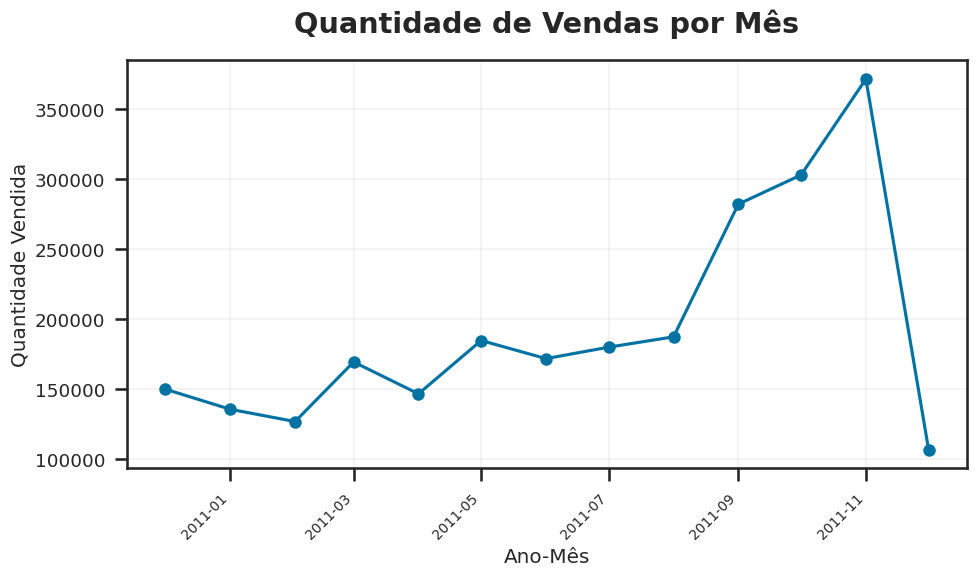

In [ ]:
# Vendas totais por mês

plt.figure(figsize=(10,6))
plt.plot(vendas_por_mes['Year-Month'], vendas_por_mes['Quantity'], marker='o', linestyle='-', color='b')
plt.title('Quantidade de Vendas por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade Vendida')

plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Ordenar pelo total de vendas (Quantity) em ordem decrescente
vendas_por_mes = vendas_por_mes.sort_values(by='Quantity', ascending=False).reset_index(drop=True)
vendas_por_mes

,Year-Month,Quantity
0,2011-11-01,371466
1,2011-10-01,302988
2,2011-09-01,282131
3,2011-08-01,187402
4,2011-05-01,184770
5,2011-07-01,180026
6,2011-06-01,171859
7,2011-03-01,169486
8,2010-12-01,149998
9,2011-04-01,146710


O mês com maior quantidade de vendas foi Novembro, seguido por Outubro (vendas sazonais - Black Friday?)

In [ ]:
clean_df = clean_df.drop(columns=['StockCode', 'Description', 'Quantity', 'Country',  'Month',
       'Year-Month'])

### Cálculo RFM

In [ ]:
# recupera a última data em timestamp
last_date = clean_df['InvoiceDate'].max()
last_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
# calculo RFM

df_rfm = (
  clean_df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (last_date - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('TotalPrice', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347.0,1,7,19.968253
12348.0,248,3,15.033333
12349.0,18,1,17.226724
12350.0,309,1,18.400000
12352.0,35,7,17.135455
...,...,...,...
18280.0,277,1,17.125000
18281.0,180,1,9.384000
18282.0,7,2,14.141250


<Axes: >

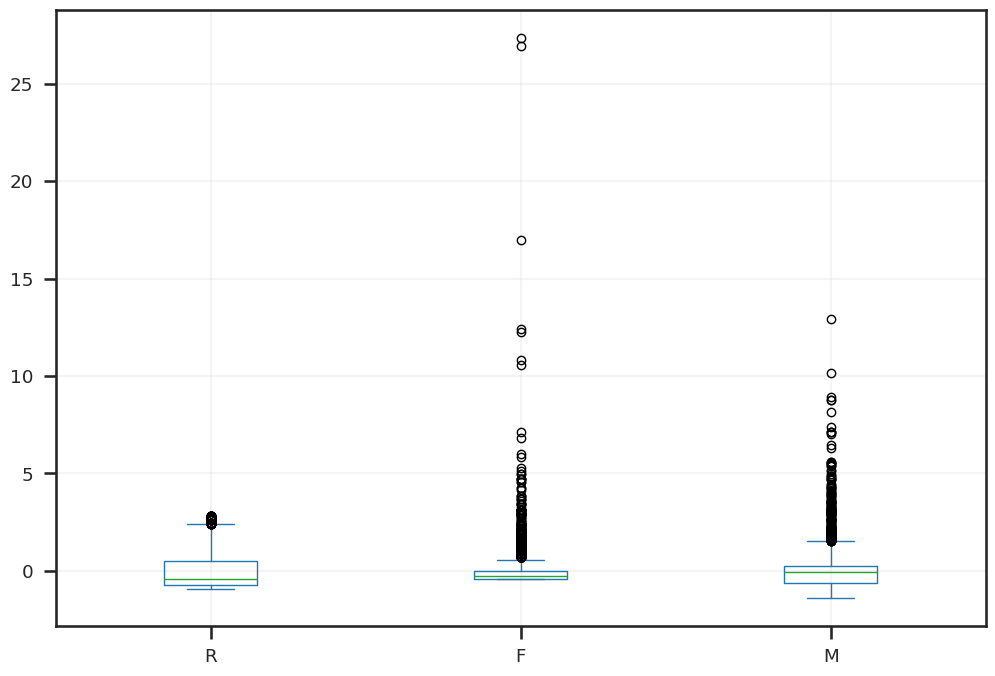

In [ ]:
# gráfico do cálculo de rfm transformado
df_rfm.apply(scale).plot.box()

In [ ]:
df_rfm.apply(scale).query('F>15')

,R,F,M
CustomerID,,,
12748.0,-0.915878,27.366418,-1.009875
14911.0,-0.915878,26.938784,0.184791
17841.0,-0.905868,16.960676,-1.061701


In [ ]:
# pesquisando os outliers de rfm no dataset parcialmente tratado
new_df[new_df['CustomerID'] == 17841.0].sort_values(by='UnitPrice', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
213999,555562,84078A,SET/4 WHITE RETRO STORAGE CUBES,1,2011-06-05 14:45:00,39.95,17841.0,United Kingdom
321280,565141,21686,MEDINA STAMPED METAL STOOL,1,2011-09-01 13:40:00,39.95,17841.0,United Kingdom
348816,567473,21686,MEDINA STAMPED METAL STOOL,1,2011-09-20 12:50:00,39.95,17841.0,United Kingdom
298160,562984,84078A,SET/4 WHITE RETRO STORAGE CUBES,1,2011-08-11 11:45:00,39.95,17841.0,United Kingdom
127200,547202,84078A,SET/4 WHITE RETRO STORAGE CUBES,1,2011-03-21 13:38:00,39.95,17841.0,United Kingdom
...,...,...,...,...,...,...,...,...
244886,558558,20668,DISCO BALL CHRISTMAS DECORATION,48,2011-06-30 13:17:00,0.12,17841.0,United Kingdom
372257,569235,20668,DISCO BALL CHRISTMAS DECORATION,48,2011-10-02 15:35:00,0.12,17841.0,United Kingdom
177493,552108,20668,DISCO BALL CHRISTMAS DECORATION,24,2011-05-06 11:36:00,0.12,17841.0,United Kingdom
451888,575298,20668,DISCO BALL CHRISTMAS DECORATION,288,2011-11-09 12:29:00,0.10,17841.0,United Kingdom


- O cliente CustomerID 12748 tem 4412 pedidos registrados no dataset parcialmente tratado (new_df);
- O cliente CustomerID 14911 tem 5670 pedidos;
- O cliente CustomerID 14911 tem 7676 pedidos;

Recomendação:
- StandardScaler: Usar se os dados forem aproximadamente normais;
- MinMaxScaler: Usar se os dados não forem gaussianos e você quiser normalizar para um intervalo fixo (0, 1);
- PowerTransformer: Usar para corrigir assimetrias nos dados e aproximá-los de uma distribuição normal.

In [ ]:
# normalização com o PowerTransformer
scaler = PowerTransformer()

### Normalização dos dados

In [ ]:
# normalização com o PowerTransformer.fit
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347.0,-1.851552,1.247400,0.534487
12348.0,1.355865,0.372575,0.067542
12349.0,-0.683107,-1.142181,0.288306
12350.0,1.575604,-1.142181,0.397269
12352.0,-0.258715,1.247400,0.279583
...,...,...,...
18280.0,1.465294,-1.142181,0.278581
18281.0,1.050666,-1.142181,-0.649497
18282.0,-1.187048,-0.157326,-0.029656


<Axes: >

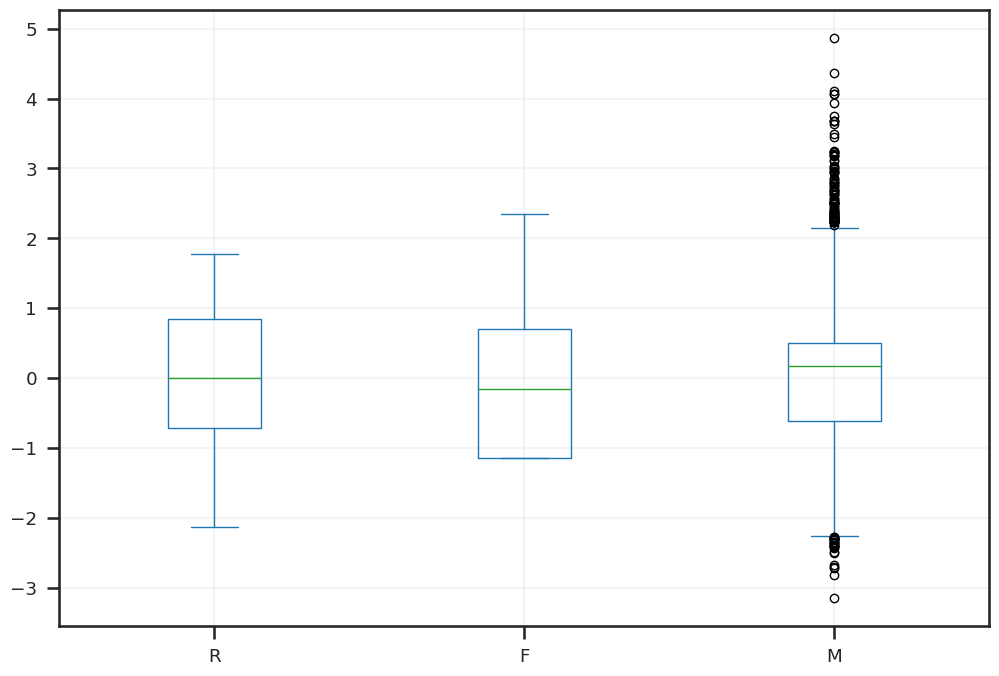

In [ ]:
# gráfico com dataset normalizado
df_rfm_scaled.plot.box()

In [ ]:
# converter de volta o valor normalizado para o valor original
scaler.inverse_transform(df_rfm_scaled)

array([[  1.        ,   7.        ,  19.96825301],
       [248.        ,   3.        ,  15.03333333],
       [ 18.        ,   1.        ,  17.22672414],
       ...,
       [  7.        ,   2.        ,  14.14125   ],
       [  3.        ,  16.        ,   2.79306834],
       [ 42.        ,   3.        ,  19.2152    ]])

In [ ]:
df_rfm.describe()

,R,F,M
count,4191.000000,4191.000000,4191.000000
mean,91.493200,4.014794,16.794301
std,99.908578,7.016195,11.609406
min,0.000000,1.000000,0.747143
25%,17.000000,1.000000,9.640935
50%,50.000000,2.000000,16.055714
75%,143.000000,4.000000,19.556600
max,373.000000,196.000000,166.800000


In [ ]:
# cortando os valores acima de 95% (para remover valores discrepantes principalmente para as colunas de frequencia e ticket médio)

df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4191.000000,4191.000000,4191.000000
mean,89.731329,3.490098,15.914387
std,95.500809,3.258305,8.126907
min,0.000000,1.000000,0.747143
25%,17.000000,1.000000,9.640935
50%,50.000000,2.000000,16.055714
75%,143.000000,4.000000,19.556600
max,310.500000,13.000000,35.307403


In [ ]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)
df_rfm_clip_scaled

,R,F,M
CustomerID,,,
12347.0,-0.929227,1.077346,0.498880
12348.0,1.657447,-0.150433,-0.108425
12349.0,-0.751197,-0.764322,0.161500
12350.0,2.296262,-0.764322,0.305886
12352.0,-0.573166,1.077346,0.150268
...,...,...,...
18280.0,1.961146,-0.764322,0.148981
18281.0,0.945326,-0.764322,-0.803647
18282.0,-0.866393,-0.457378,-0.218207


## Pipeline de pré-processamento do modelo


In [ ]:
# Remoção de nulos
customer = customer.dropna()

# Remoção de duplicados
customer = customer.drop_duplicates()

# remover colunas desnecessárias
customer.drop(columns=['StockCode', 'Description', 'Quantity', 'Country'])

# conversão de formatos de dados
customer['CustomerID'] = customer['CustomerID'].astype('object')
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'])

# Remoção de valores negativos ou inválidos
customer = customer[customer['Quantity'] >= 0]
customer = customer[customer['UnitPrice'] > 0.00]

# Função customizada para identificar outlier

def is_outlier (array, extreme = False):
  """Função customizada para identificar outliers em um array"""
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor * iqr
  lower_outlier = q1 - factor * iqr
  return (array < lower_outlier)|(array > upper_outlier)


# Função para remover outliers com base na função is_outlier que identifica outliers
def remove_outliers(df, columns, extreme=False):
    """Remove outliers from specified columns in a DataFrame"""
    df = df.copy()
    for col in columns:
        outliers = is_outlier(df[col], extreme)
        df = df[~outliers]
    return df


customer_cleaned = remove_outliers(customer, columns=['UnitPrice', 'Quantity'])

# Cálculo do preço total por item
customer_cleaned['TotalPrice'] = customer_cleaned['Quantity'] * customer_cleaned['UnitPrice']

# recuperar a última data em timestamp
last_date = customer_cleaned['InvoiceDate'].max()

# calculo RFM

customer_rfm = (
  customer_cleaned.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (last_date - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('TotalPrice', 'mean')
  )
)

# normalização com o PowerTransformer
scaler = PowerTransformer()
customer_rfm_scaled = pd.DataFrame(scaler.fit_transform(customer_rfm), index=customer_rfm.index, columns=customer_rfm.columns)

# cortando os valores acima de 95% (para remover valores discrepantes principalmente para as colunas de frequencia e ticket médio)
customer_rfm_clip = customer_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))

# padronizando o df_rfm_clip
customer_rfm_clip_scaled = customer_rfm_clip.apply(scale)

print(f'Dataset com dados de Recência, Frequência e Ticket Médio por Cliente:')
customer_rfm_clip_scaled

Dataset com dados de Recência, Frequência e Ticket Médio por Cliente:


,R,F,M
CustomerID,,,
12347.0,-0.929227,1.077346,0.498880
12348.0,1.657447,-0.150433,-0.108425
12349.0,-0.751197,-0.764322,0.161500
12350.0,2.296262,-0.764322,0.305886
12352.0,-0.573166,1.077346,0.150268
...,...,...,...
18280.0,1.961146,-0.764322,0.148981
18281.0,0.945326,-0.764322,-0.803647
18282.0,-0.866393,-0.457378,-0.218207


## Modeling

1. Escolher um algoritmo adequado para base de dados, como o K-Means, DBSCAN, Hierarquia ou Mean Shift
2. Encontrar a quantidade ideal de clusters através dos métodos de Elbow ou Silhouette Score
3. Implementar o algoritmo escolhido

### K-means

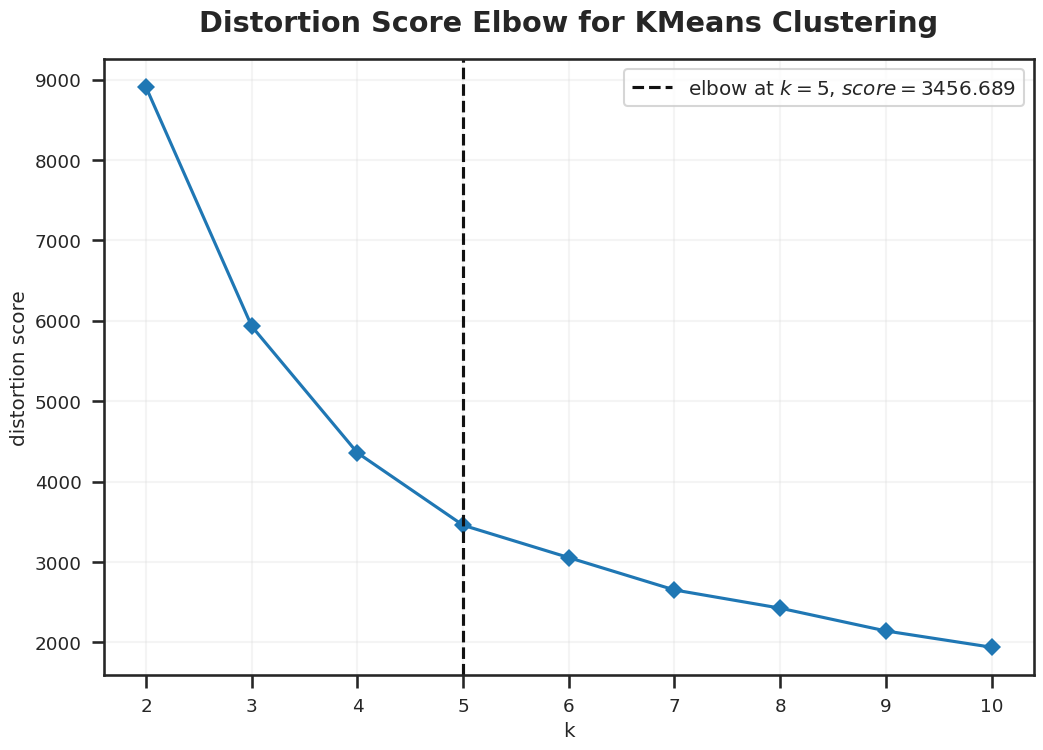

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
kelbow_visualizer(KMeans(), customer_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Create list of metrics in dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = customer_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=42)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8905.268429,0.332954,1.171705,1725.291765
3,5931.234981,0.380321,0.986540,2344.849933
4,4357.501895,0.353671,0.933701,2631.380575
5,3908.719842,0.340059,0.980635,2319.746562
6,3034.411946,0.370250,0.908553,2631.094316
7,2680.331409,0.345258,0.983741,2573.761529
8,2343.573542,0.356982,0.938801,2608.336353
9,2127.019300,0.356817,0.899994,2567.271680
10,1886.233830,0.366644,0.856419,2632.015456


- Inertia: Útil para acompanhar a convergência de algoritmos como K-Means, mas não indica diretamente a qualidade dos clusters;
- Silhouette Score: Indicador geral de qualidade, especialmente para decidir o número de clusters;
- Davies-Bouldin Score: Menos intuitivo, mas útil em cenários com clusters complexos;
- Calinski-Harabasz Score: Focado em separar clusters densos e bem distribuídos.

**Observações:**
1. **silhouette:** quando mais próximo de 1, melhor;
2. **davies_bouldin:** quais mais próximo de 0, melhor;
3. **calinski_harabasz:** quando maior o valor, melhor.

**Avaliação**
- Inertia apresenta uma diminuição significativa até k = 4, após o qual as reduções tornam-se mais sutis.
- Silhouette Score atinge seu pico em k = 3, mas para k = 4 o valor ainda está bom (considerando a Inercia também).

Diante disso, consideraremos 4 clusters.


In [ ]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(customer_rfm_clip_scaled)

In [ ]:
px.scatter_3d(customer_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

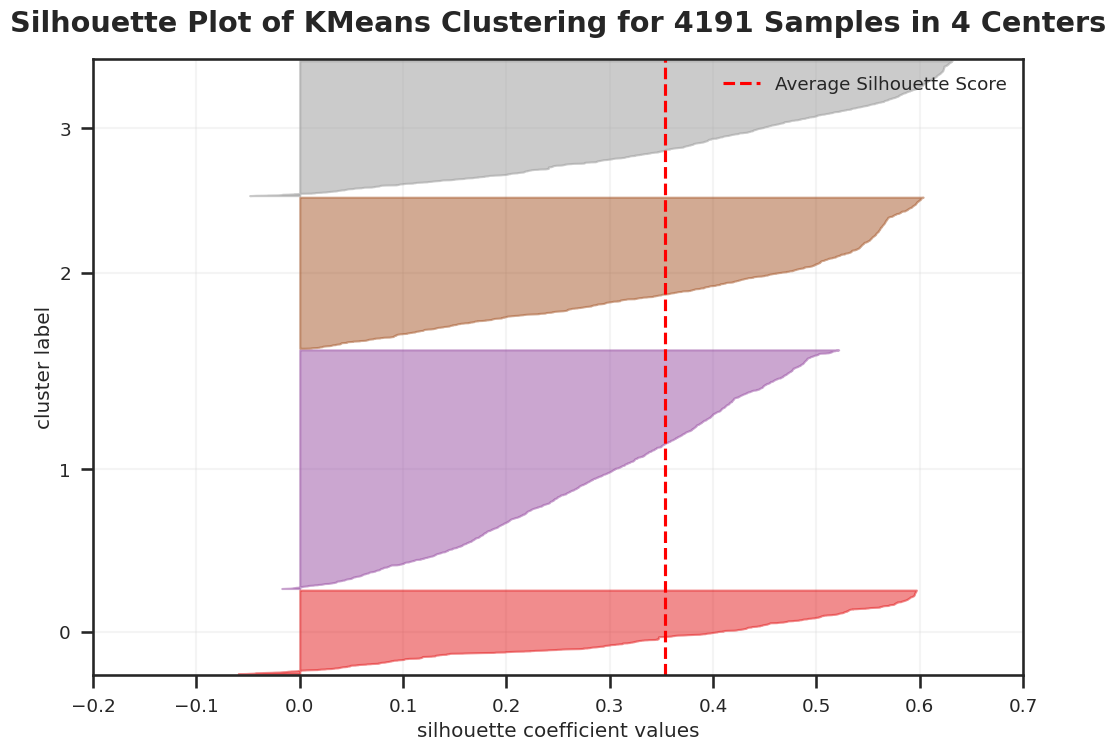

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4191 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4))

In [ ]:
# silhouette_visualizer
silhouette_visualizer(KMeans(n_clusters=4), X)

### Classificação hierárquica

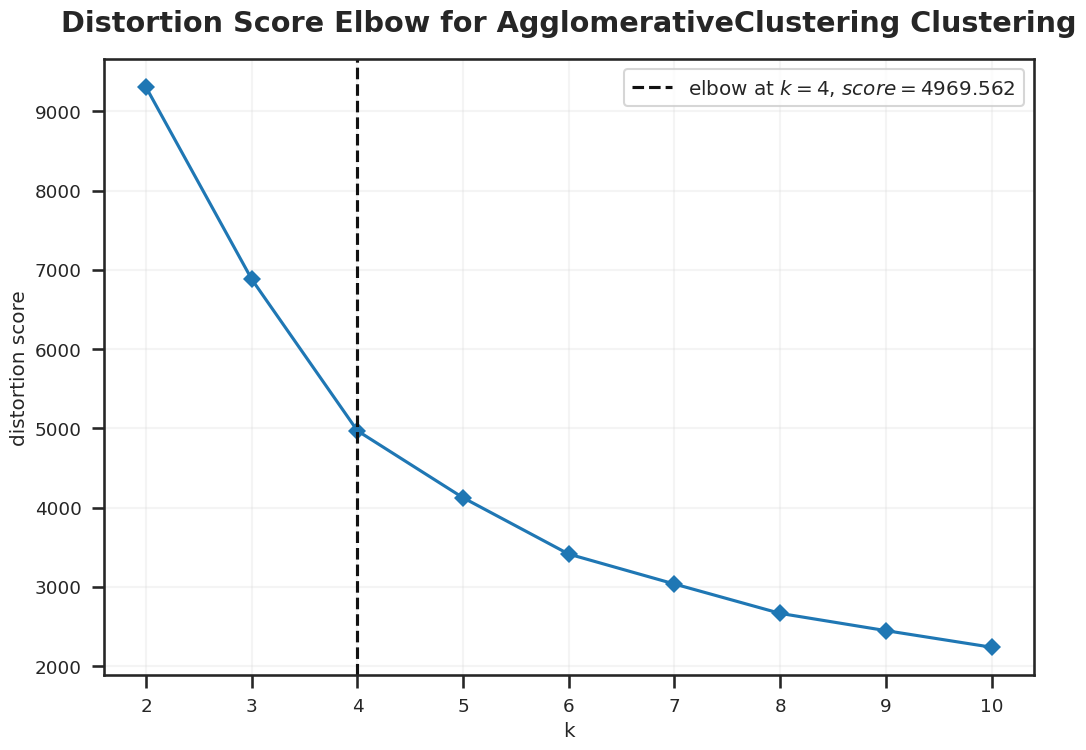

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), customer_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = customer_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.310182,1.059775,1471.512977
3,0.332146,0.948961,1732.009885
4,0.377139,0.879505,2135.372263
5,0.318966,0.928313,2143.747974
6,0.319191,0.994095,2246.020264
7,0.319399,0.978550,2190.615648
8,0.319704,1.008630,2221.331511
9,0.310047,0.987554,2162.242778
10,0.313040,0.959368,2144.907992


In [ ]:
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(customer_rfm_clip_scaled)

In [ ]:
px.scatter_3d(customer_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

<ipython-input-92-c0fda4cc17a6>:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'CustomerID
12347.0    1.284672
12348.0    0.371035
12349.0   -1.143250
12350.0   -1.143250
12352.0    1.284672
             ...   
18280.0   -1.143250
18281.0   -1.143250
18282.0   -0.166368
18283.0    1.750192
18287.0    0.371035
Name: F, Length: 4191, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



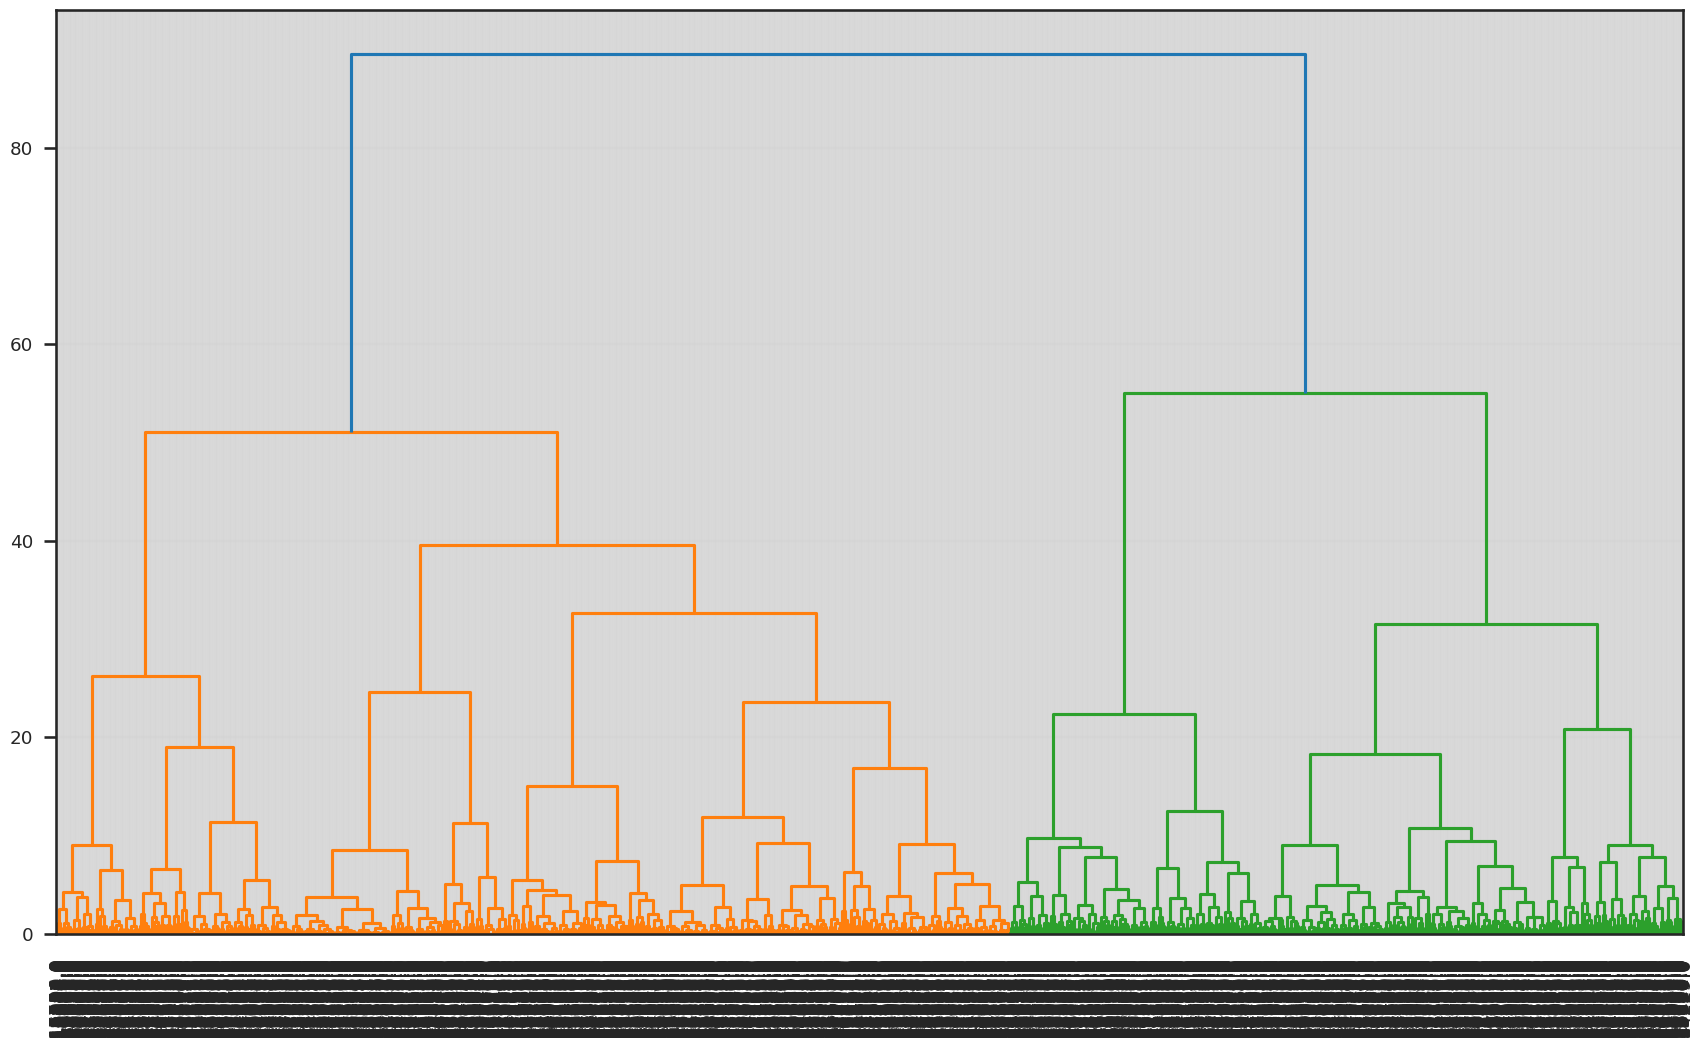

In [ ]:
# dataset transformado
X = customer_rfm_clip.copy()
X[:] = scaler.fit_transform(X)


plt.figure(figsize=(21,12))
Z = linkage(X, method='ward')
dendrogram_dict = dendrogram(Z, labels=X.index)
plt.xticks(fontsize=14)
plt.show()

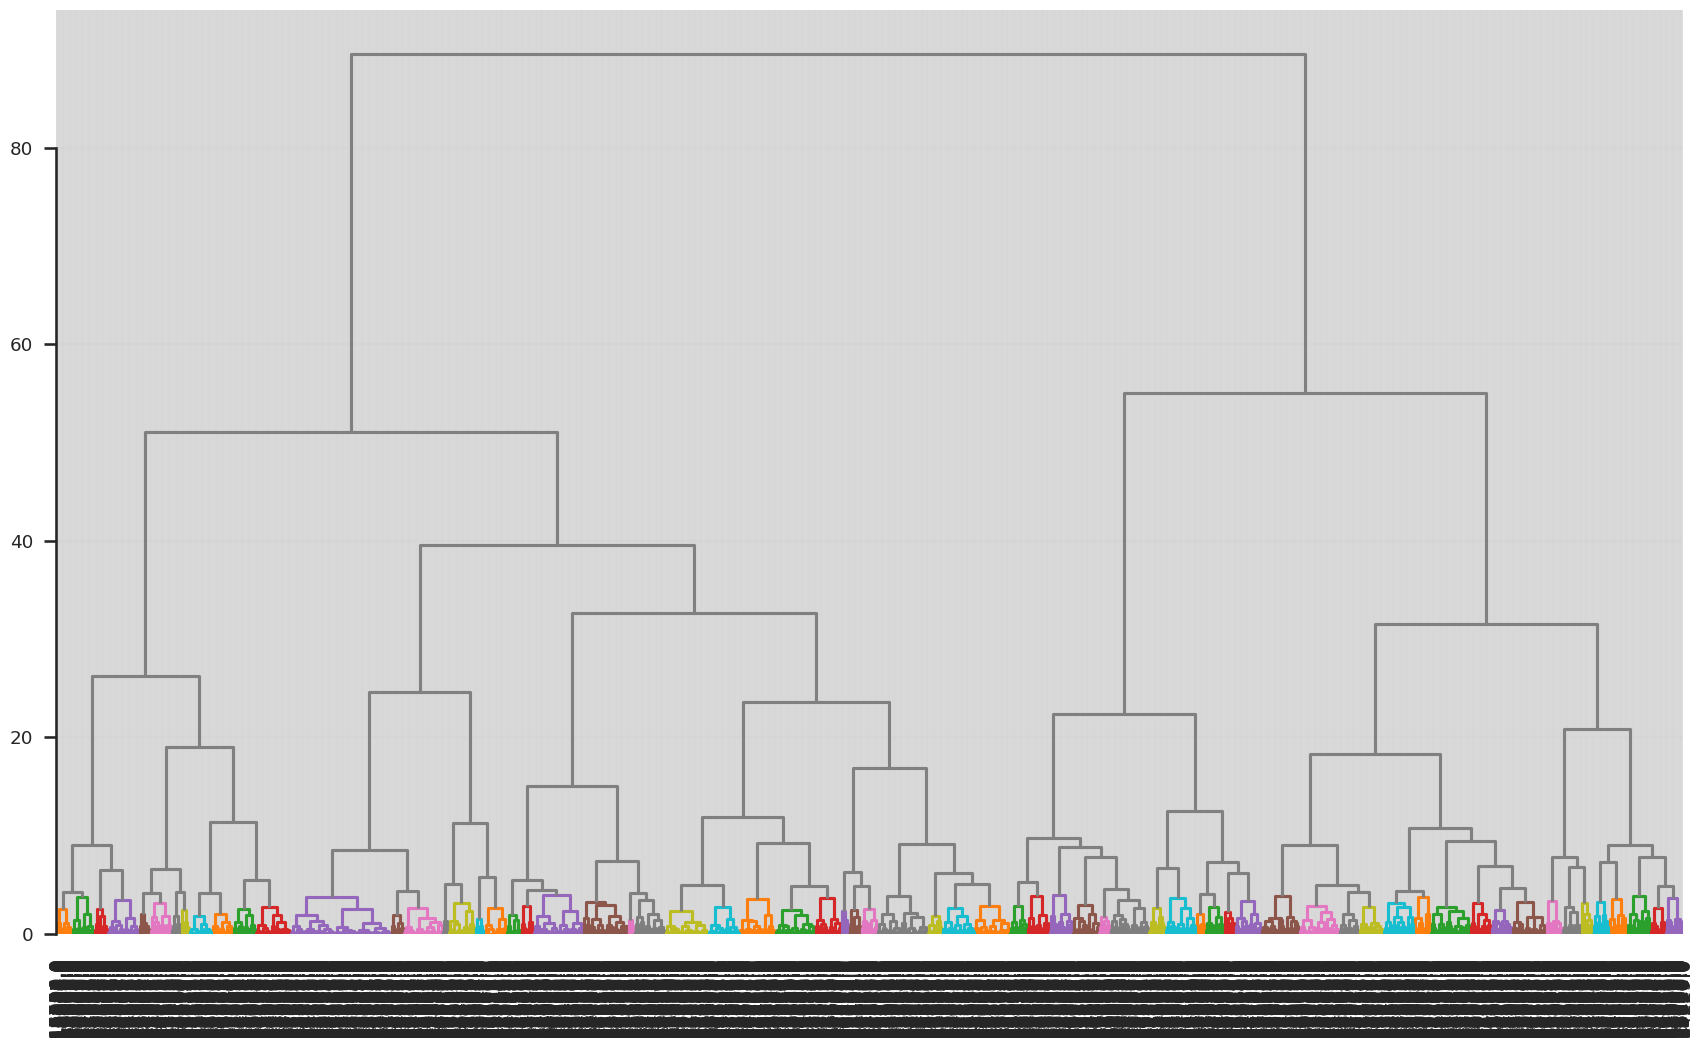

In [ ]:
plt.figure(figsize=(21,12))

Z = linkage(X, method='ward')
dendrogram_dict = dendrogram(Z, labels=X.index, color_threshold=4, above_threshold_color='gray')

sns.despine(bottom=True, trim=True)
plt.xticks(fontsize=14)
plt.show()

## Evaluation

#### Analise dos clusters obtidos

1. Identificar os padrões e características em comum entre os clientes
2. Plotar gráficos para auxiliar na análise

#### Clusters Kmeans

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=customer_rfm_clip_scaled.columns)

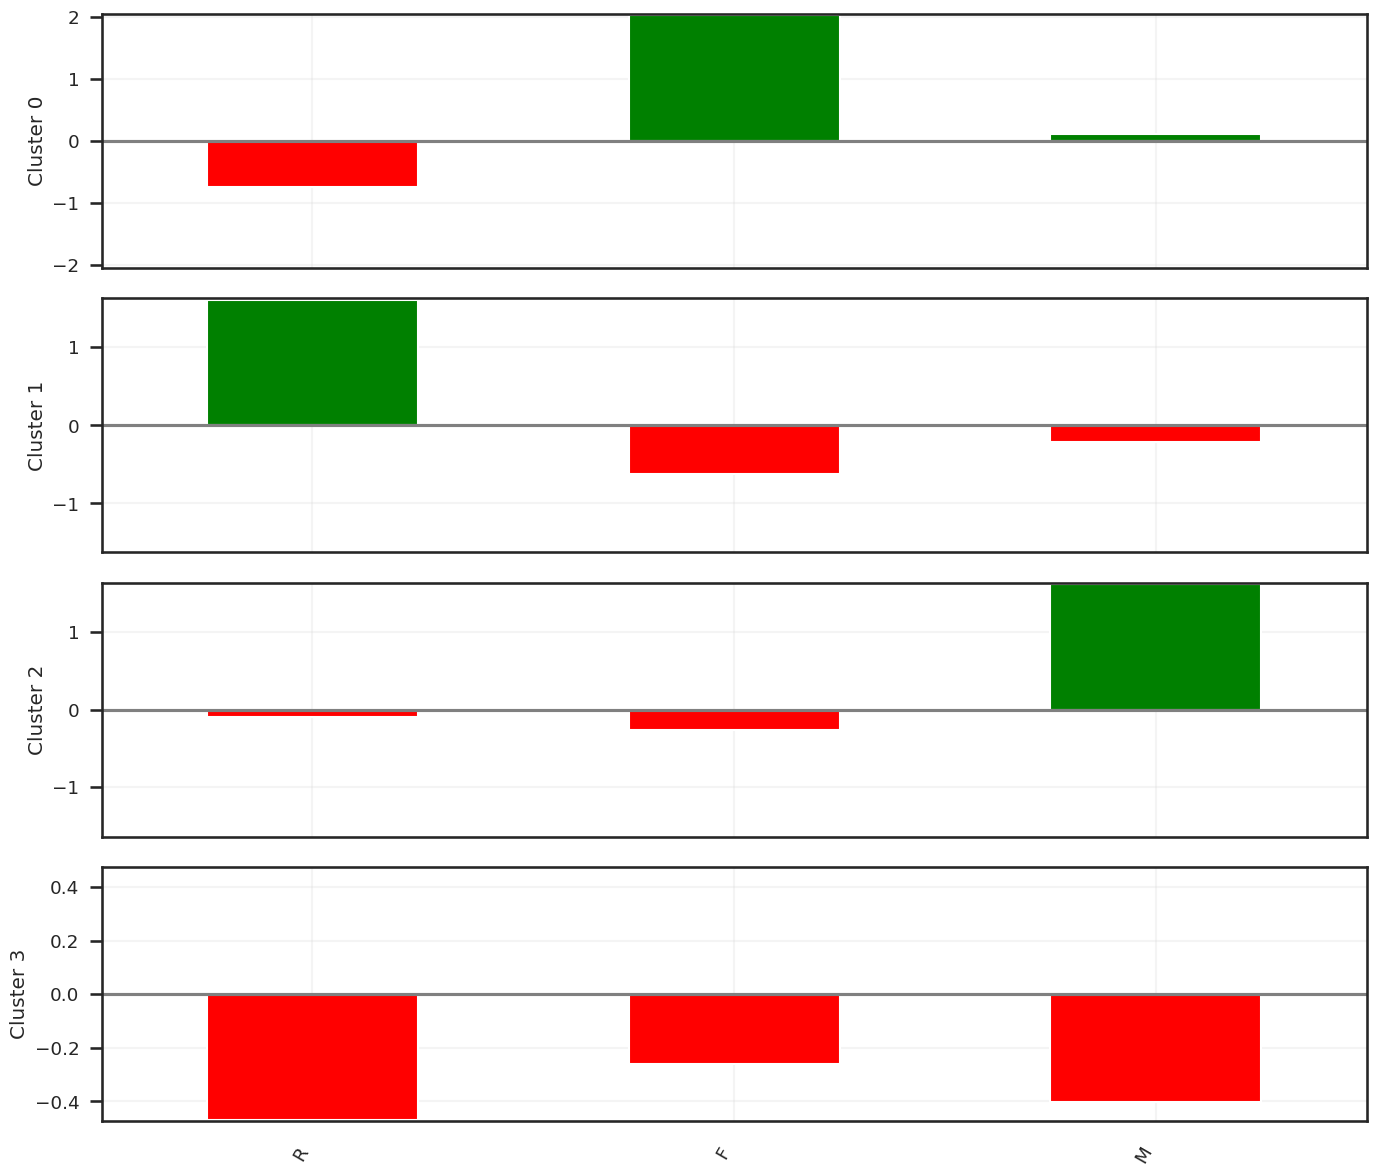

In [ ]:
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  customer_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)

)

cluster,0,1,2,3
R,19.165600,243.510349,81.372449,44.998058
F,10.084800,1.440087,2.644558,2.644175
M,16.883018,14.183804,29.109830,12.625242


#### Clusters classificação hierárquica


In [ ]:
centers_hclust = (
    customer_rfm_clip_scaled
    .assign(cluster=hclust_labels)
    .groupby('cluster')
    .mean()
)

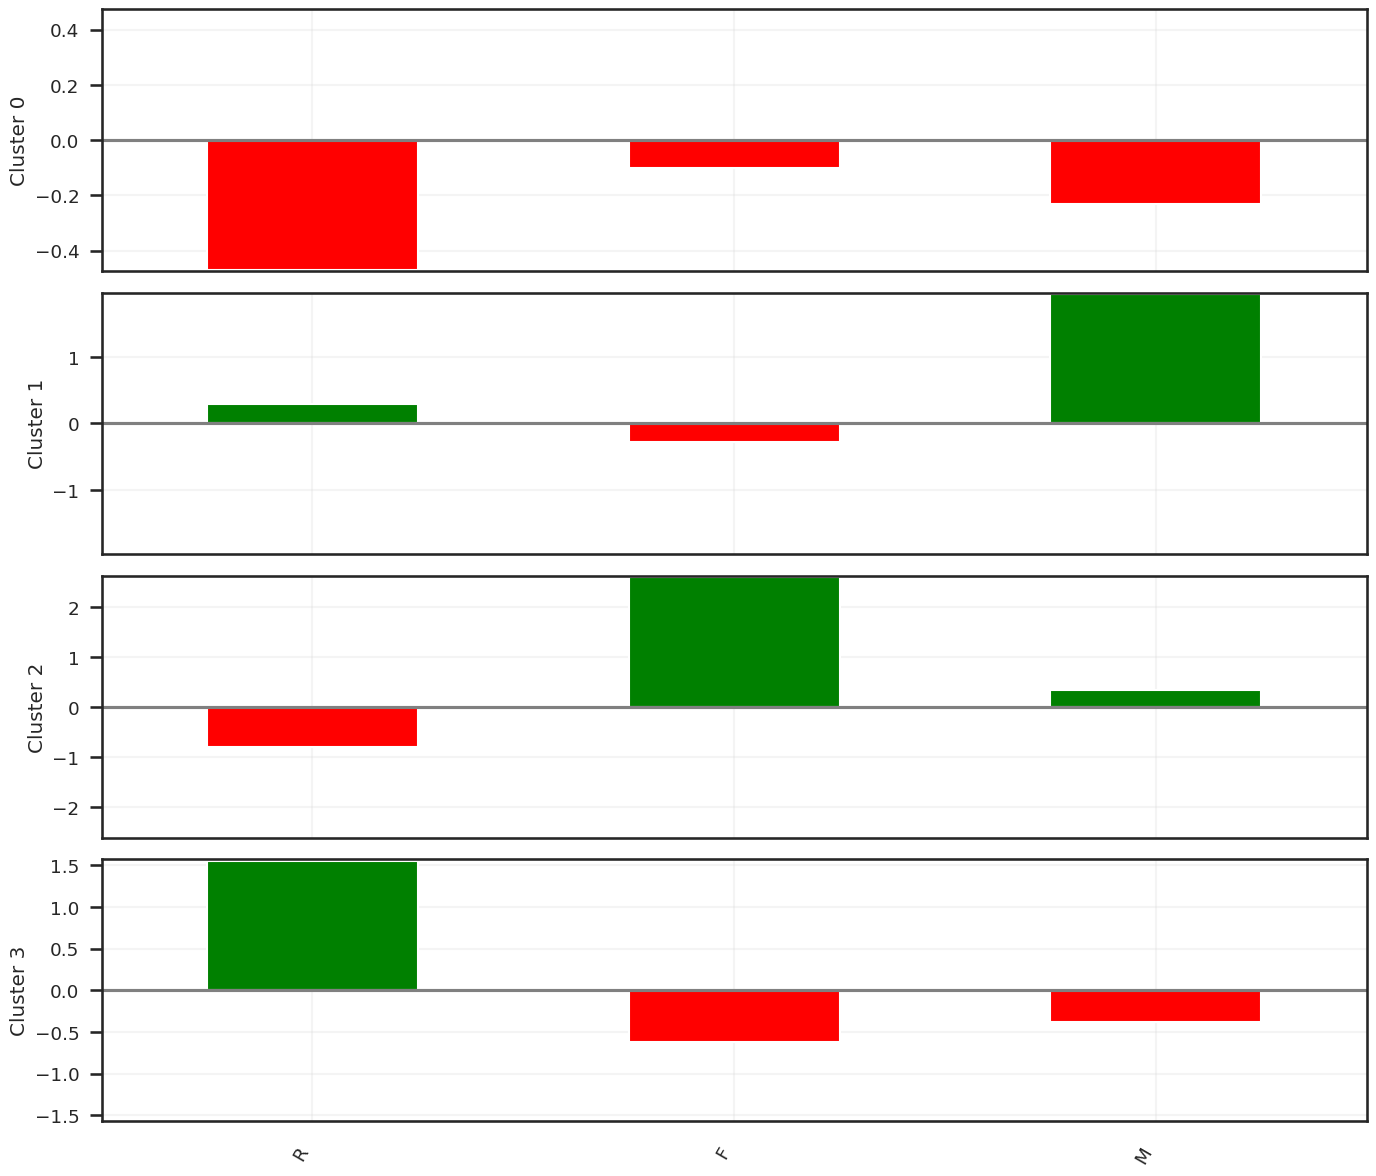

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(14, 12), sharex=True)

for i, ax in enumerate(axes):
    center = centers_hclust.loc[i, :]
    maxPC = 1.01 * center.abs().max()
    colors = ['green' if l > 0 else 'red' for l in center]
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)
    ax.axhline(color='gray')
    ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
    customer_rfm_clip
    .assign(cluster=hclust_labels)
    .groupby('cluster')
    .mean()
    .transpose()
    .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,44.954706,117.222087,12.966102,238.336000
F,3.159608,2.575243,11.940678,1.465143
M,14.035842,31.810786,18.654610,12.795458


### Interpretação dos resultados obtidos com K-means

- Embora o silhouette seja mais alto na classificação hierárquica, a diferença entre 0,377139 (hierarquia) e 0,353671 (K-Means) é pequena. O desempenho do K-Means é aceitável com um índice de silhouette razoável. Esse ganho marginal pode não compensar a inviabilidade computacional da hierárquica para um conjunto de dados tão grande.

- O K-Means pode ser mais estável para conjuntos de dados grandes e estruturados, como esse, porque a classificação hierárquica pode ser sensível a ruídos ou outliers.
A hierárquica oferece flexibilidade na escolha dos clusters, mas sua aplicação prática em um volume de dados tão grande pode levar a desafios significativos de memória e tempo.
- Levando em consideração o custo computacional:
  - O K-Means processa grandes volumes de dados com relativa rapidez e permite otimizações adicionais;
  - A Classificação Hierárquica é altamente custosa em termos de tempo e memória. Geralmente, ela é utilizada para conjuntos de dados pequenos ou amostras reduzidas.

Diante desse contexto, o K-Means é a escolha mais adequada para este cenário devido à sua eficiência computacional, escalabilidade e robustez para grandes conjuntos de dados.


**1. Perfil de compras dos clientes de cada cluster**

De acordo com os resultados apresentados em cada coluna identificamos os seguintes perfis de clientes:

Análise por Cluster:

- Cluster 0: Clientes moderadamente recentes que compraram ocasionalmente e gastam pouco.
São clientes de baixo valor e engajamento moderado.

- Cluster 1: Clientes que não compram há muito tempo (muito inativos), que compraram apenas uma vez ou muito raramente, e que gastam moderadamente quando compram.
São clientes inativos que ainda têm um valor médio considerável.

- Cluster 2: São clientes moderadamente recentes, que frequência ocasional semelhante ao Cluster 0 e gastam mais que os clientes do Cluster 0.
São clientes com potencial de crescimento.

- Cluster 3: São clientes que compraram recentemente (clientes mais engajados), compraram com muita frequência e gastam moderadamente, mas com alta recorrência.
Ou seja, são clientes de alto engajamento e boa frequência.

**2. Como essa análise pode ser útil para empresa para segmentação de seus clientes e personalização das campanhas de marketing?**

Com essa segmentação a empresa pode afunilar melhor e personalizar o tipo de campanha de marketing para alcançar cada grupo.

**3. Possíveis ações com base nas ações realizadas**

Ações possíveis:

- Cluster 0 (Clientes ocasionais de baixo valor):
Estimule compras repetidas com cupons e ofertas por tempo limitado.
Promova itens de maior valor agregado para aumentar o ticket médio.

- Cluster 1 (Clientes inativos):
Campanhas de reativação com descontos e e-mails personalizados.
Destaque novos produtos ou serviços para atrair o interesse.

- Cluster 2 (Clientes moderados com potencial):
Aumente a frequência de compras com promoções personalizadas.
Realize campanhas educacionais ou recomendações de produtos relevantes.

- Cluster 3 (Clientes altamente engajados):
Ofereça benefícios exclusivos, como programas de fidelidade ou ofertas VIP, para manter a lealdade.
Explore cross-selling e up-selling.





